In [1]:
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_random_seed(seed)

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

In [3]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    X = []
    Y = []
    for i in range(5):
        X_, Y_ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
        Y.extend(Y_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X, Y

def load_test_data():
    X_, Y = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X, Y

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

# Load cifar-10 data
train_samples, train_labels= load_train_data() 
test_samples, test_labels = load_test_data()

train_samples = train_samples/255.0
test_samples = test_samples/255.0
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

In [ ]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 100
        self.batch_size = 32 #32 => 64
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 64
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        self.img_size = 32
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])
        self.tracked_label = np.delete(np.transpose(np.tile(np.eye(10), 7)), np.s_[-6:], 0)

        self.real_input = tf.placeholder(tf.float32,
                                         [None, self.img_size, self.img_size, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.condition_label = tf.placeholder(tf.float32, [None, 10])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, self.img_size, self.img_size, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input, y_fill):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        
        # input:(?, self.img_size=32, self.img_size=32, 3)
        # c_label (?, 10) one hot
        # y_fill: (?, 32, 32, 10) label one hot (y_i = 4,then y_fill_i =(i, :, :, 4) =1
        
        
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            
            dis_cat = tf.concat([input, y_fill], -1)
            dis_conv1 = conv2d(dis_cat, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            return dis_fc4

    def _generator(self, input, c_label):
        # input (?, self.code_size=64)
        # c_label (?, 10) one hot

        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_cat = tf.concat([input, c_label], 1)
            
            gen_fc1 = fc(gen_cat, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4
        
        
    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        # reshape
        y_label_ = tf.reshape(self.condition_label, [-1, 1, 1, 10])
        bsize = tf.shape(self.condition_label)[0]
        y_fill_ = y_label_ * tf.ones([bsize, self.img_size, self.img_size, 10])
        
        # self.fake_samples_op = None
        self.fake_samples_op = self._generator(self.noise, self.condition_label)
        
        self.dis_loss_op = self._loss(self.real_label, 
                                      self._discriminator(self.real_input, y_fill_)
                                      ) + self._loss(self.fake_label,
            self._discriminator(self.fake_samples_op, y_fill_))
        
        # self.gen_loss_op = None
        self.gen_loss_op = self._loss(self.real_label,
                                      self._discriminator(self.fake_samples_op, y_fill_))
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        
        # dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        # self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op)
        dis_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "dis")
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op,
                                                   var_list=dis_train_vars)
        
        # gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        # self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op)
        gen_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "gen")
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op,
                                                  var_list=gen_train_vars)
        
        ################################################################################
        # Prob 2-4: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        self.actmax_sample_op = self._generator(self.actmax_code, self.condition_label)
        actmax_dis = self._discriminator(self.actmax_sample_op, y_fill_)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        # Prob 2-4: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # self.recon_loss_op = None
        self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        
        # recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        
        # self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)
        
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples, test_labels):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        print('Start training ...')
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                batch_labels = train_labels[i * self.batch_size : (i + 1) * self.batch_size]
                #noise = np.random.normal(0, 1, [batch_labels.shape[0], self.code_size])
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # dis_feed_dict = {}
                dis_feed_dict = {self.real_input:batch_samples, self.real_label:zeros,
                                self.fake_label:ones, self.noise:noise, self.is_train:True,
                                self.condition_label:batch_labels}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################
                #print('batch', batch_labels.shape, 'noise', noise.shape)

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # gen_feed_dict = {}
                gen_feed_dict = {self.noise:noise, self.real_label:zeros,
                                 self.fake_label:ones, self.is_train:True,
                                 self.condition_label:batch_labels}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            ax1.imshow(viz_grid(self.generate(self.tracked_noise), 1))
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
        print('... Done!')

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        
        ################################################################################
        # Prob 2-4: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # actmax_init_val = None
        # sample <class 'numpy.ndarray'> (1, 32, 32, 3)
        # sample_tf = tf.convert_to_tensor(sample, dtype = tf.float32)
        actmax_init_val = np.random.normal(0, 1, [1, self.code_size])
        
        self.condition_label = np.eye(10)
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-4: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-4     #
            ################################################################################   
            confeed = np.zeros((1,10))
            confeed[i%10] = 1
            
            # recon_feed_dict = {}
            recon_feed_dict = {self.recon_sample: sample, self.actmax_label: np.ones([1, 1]),
                               self.is_train: True, self.condition_label:confeed }
            
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code, label):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################
        
        # gen_vis_feed_dict = {}
        gen_vis_feed_dict = {self.noise:code, self.is_train:False,
                             self.condition_label:label
                            }
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 32, 32, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1], one_hot_encode([i%10]))
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-4: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)



In [ ]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, y_label: fixed_y_, isTrain: False})

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (img_size, img_size)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


Start training ...
Iteration 50/156200: dis loss = 1.1482, gen loss = 0.9068
Iteration 100/156200: dis loss = 0.2252, gen loss = 2.7047
Iteration 150/156200: dis loss = 0.2608, gen loss = 2.3467
Iteration 200/156200: dis loss = 0.4341, gen loss = 1.7194
Iteration 250/156200: dis loss = 0.2600, gen loss = 2.5206
Iteration 300/156200: dis loss = 0.2567, gen loss = 2.4172
Iteration 350/156200: dis loss = 0.5608, gen loss = 3.4096
Iteration 400/156200: dis loss = 1.1508, gen loss = 1.0595
Iteration 450/156200: dis loss = 0.8978, gen loss = 1.1801
Iteration 500/156200: dis loss = 1.0405, gen loss = 0.8500
Iteration 550/156200: dis loss = 0.7476, gen loss = 1.2511
Iteration 600/156200: dis loss = 0.6284, gen loss = 1.9190
Iteration 650/156200: dis loss = 1.2682, gen loss = 2.1970
Iteration 700/156200: dis loss = 1.3171, gen loss = 2.6431
Iteration 750/156200: dis loss = 1.1516, gen loss = 0.7629
Iteration 800/156200: dis loss = 0.6806, gen loss = 1.5334
Iteration 850/156200: dis loss = 1.056

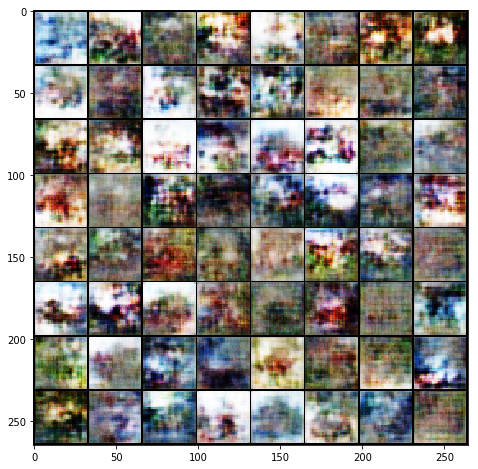

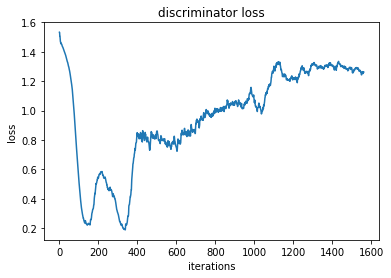

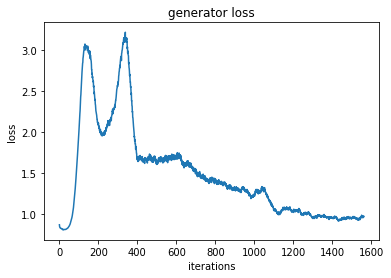

Iteration 1600/156200: dis loss = 1.2082, gen loss = 0.8545
Iteration 1650/156200: dis loss = 1.0311, gen loss = 1.3471
Iteration 1700/156200: dis loss = 1.2134, gen loss = 1.0541
Iteration 1750/156200: dis loss = 1.2094, gen loss = 0.7582
Iteration 1800/156200: dis loss = 1.1193, gen loss = 1.1983
Iteration 1850/156200: dis loss = 1.1146, gen loss = 0.7496
Iteration 1900/156200: dis loss = 0.7610, gen loss = 1.3591
Iteration 1950/156200: dis loss = 0.9750, gen loss = 1.0282
Iteration 2000/156200: dis loss = 0.9549, gen loss = 1.4077
Iteration 2050/156200: dis loss = 1.1468, gen loss = 1.0255
Iteration 2100/156200: dis loss = 1.0308, gen loss = 1.3811
Iteration 2150/156200: dis loss = 1.1101, gen loss = 0.7497
Iteration 2200/156200: dis loss = 1.0003, gen loss = 0.9473
Iteration 2250/156200: dis loss = 1.1148, gen loss = 1.1861
Iteration 2300/156200: dis loss = 1.3554, gen loss = 0.7184
Iteration 2350/156200: dis loss = 1.0422, gen loss = 1.7564
Iteration 2400/156200: dis loss = 1.0270

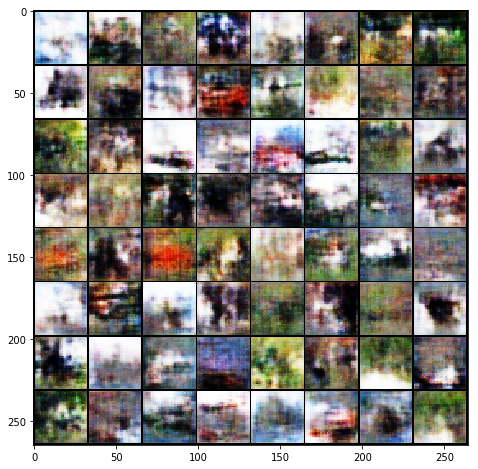

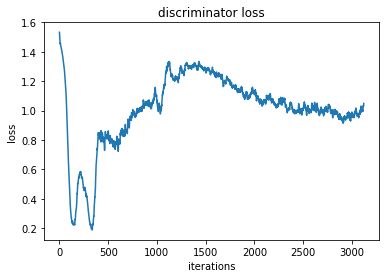

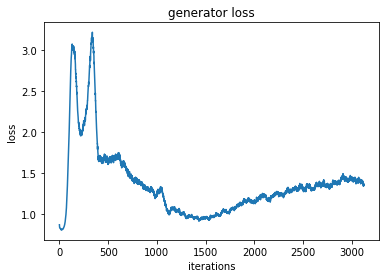

Iteration 3150/156200: dis loss = 1.0422, gen loss = 1.0563
Iteration 3200/156200: dis loss = 0.8215, gen loss = 1.4098
Iteration 3250/156200: dis loss = 0.9481, gen loss = 1.3664
Iteration 3300/156200: dis loss = 1.2740, gen loss = 0.7014
Iteration 3350/156200: dis loss = 0.9189, gen loss = 1.6881
Iteration 3400/156200: dis loss = 1.4277, gen loss = 1.4243
Iteration 3450/156200: dis loss = 1.0976, gen loss = 0.9362
Iteration 3500/156200: dis loss = 1.1479, gen loss = 1.4494
Iteration 3550/156200: dis loss = 1.0875, gen loss = 1.0758
Iteration 3600/156200: dis loss = 1.4018, gen loss = 1.6339
Iteration 3650/156200: dis loss = 1.1869, gen loss = 1.6814
Iteration 3700/156200: dis loss = 1.1261, gen loss = 1.0611
Iteration 3750/156200: dis loss = 1.3858, gen loss = 1.4780
Iteration 3800/156200: dis loss = 1.2184, gen loss = 1.2501
Iteration 3850/156200: dis loss = 1.0891, gen loss = 1.8510
Iteration 3900/156200: dis loss = 1.2171, gen loss = 0.6711
Iteration 3950/156200: dis loss = 1.2234

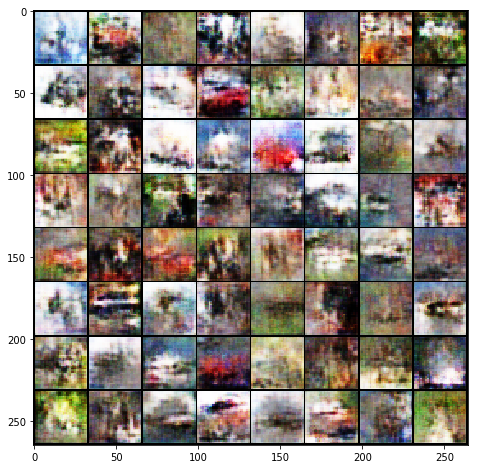

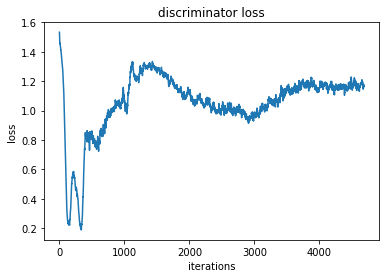

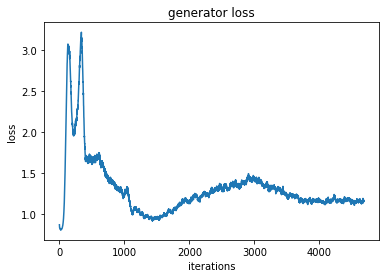

Iteration 4700/156200: dis loss = 1.3302, gen loss = 0.7952
Iteration 4750/156200: dis loss = 1.2242, gen loss = 1.4355
Iteration 4800/156200: dis loss = 1.1260, gen loss = 0.8149
Iteration 4850/156200: dis loss = 1.2533, gen loss = 0.9181
Iteration 4900/156200: dis loss = 1.0721, gen loss = 1.4093
Iteration 4950/156200: dis loss = 1.0835, gen loss = 1.1611
Iteration 5000/156200: dis loss = 1.2052, gen loss = 0.7600
Iteration 5050/156200: dis loss = 1.1277, gen loss = 0.9408
Iteration 5100/156200: dis loss = 0.7928, gen loss = 1.7016
Iteration 5150/156200: dis loss = 1.1365, gen loss = 0.7732
Iteration 5200/156200: dis loss = 1.2646, gen loss = 0.6965
Iteration 5250/156200: dis loss = 1.0563, gen loss = 0.9219
Iteration 5300/156200: dis loss = 0.9446, gen loss = 1.1679
Iteration 5350/156200: dis loss = 1.1870, gen loss = 0.8377
Iteration 5400/156200: dis loss = 0.9935, gen loss = 1.4612
Iteration 5450/156200: dis loss = 1.0989, gen loss = 1.0497
Iteration 5500/156200: dis loss = 0.9419

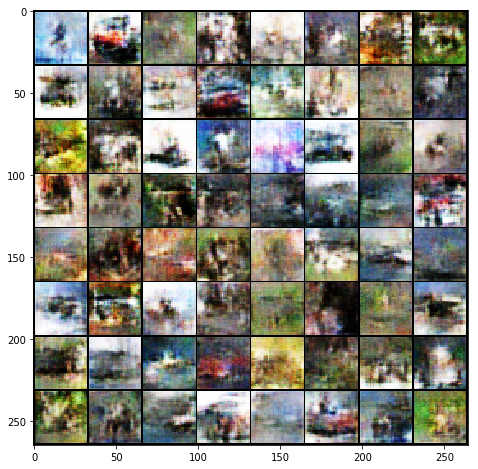

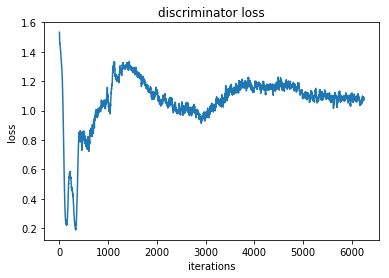

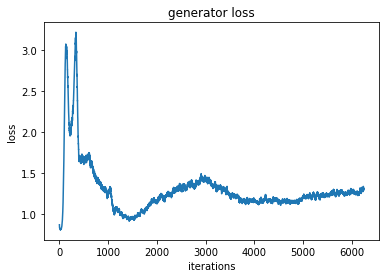

Iteration 6250/156200: dis loss = 1.0488, gen loss = 1.0607
Iteration 6300/156200: dis loss = 1.0270, gen loss = 0.9446
Iteration 6350/156200: dis loss = 1.1492, gen loss = 0.7426
Iteration 6400/156200: dis loss = 1.2029, gen loss = 1.0028
Iteration 6450/156200: dis loss = 1.2132, gen loss = 0.6936
Iteration 6500/156200: dis loss = 0.7820, gen loss = 2.0323
Iteration 6550/156200: dis loss = 1.0166, gen loss = 1.3477
Iteration 6600/156200: dis loss = 0.9331, gen loss = 1.2320
Iteration 6650/156200: dis loss = 1.1336, gen loss = 1.5532
Iteration 6700/156200: dis loss = 0.7528, gen loss = 1.3879
Iteration 6750/156200: dis loss = 0.9747, gen loss = 0.9509
Iteration 6800/156200: dis loss = 1.1260, gen loss = 0.7783
Iteration 6850/156200: dis loss = 0.8720, gen loss = 1.1573
Iteration 6900/156200: dis loss = 0.9493, gen loss = 0.9193
Iteration 6950/156200: dis loss = 1.0448, gen loss = 1.0125
Iteration 7000/156200: dis loss = 1.4189, gen loss = 0.6367
Iteration 7050/156200: dis loss = 0.8862

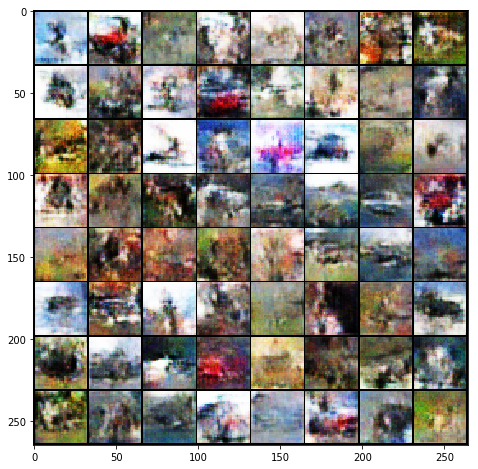

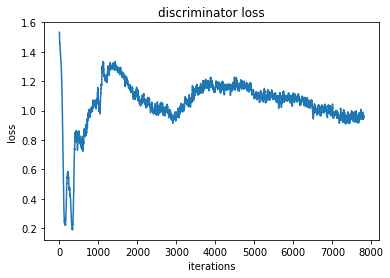

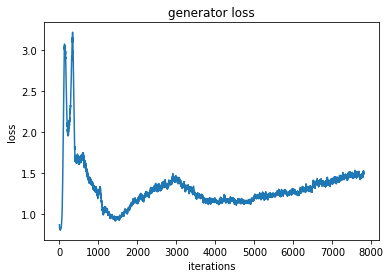

Iteration 7850/156200: dis loss = 0.9378, gen loss = 0.8787
Iteration 7900/156200: dis loss = 0.8433, gen loss = 2.2318
Iteration 7950/156200: dis loss = 0.9638, gen loss = 0.9616
Iteration 8000/156200: dis loss = 0.9046, gen loss = 1.0016
Iteration 8050/156200: dis loss = 0.7369, gen loss = 1.7377
Iteration 8100/156200: dis loss = 0.7279, gen loss = 1.4259
Iteration 8150/156200: dis loss = 0.7206, gen loss = 1.3223
Iteration 8200/156200: dis loss = 0.8949, gen loss = 1.4514
Iteration 8250/156200: dis loss = 1.5242, gen loss = 2.4582
Iteration 8300/156200: dis loss = 0.7265, gen loss = 2.5376
Iteration 8350/156200: dis loss = 0.7867, gen loss = 1.5497
Iteration 8400/156200: dis loss = 0.9772, gen loss = 2.0413
Iteration 8450/156200: dis loss = 0.8923, gen loss = 0.9586
Iteration 8500/156200: dis loss = 1.0444, gen loss = 1.7061
Iteration 8550/156200: dis loss = 0.7983, gen loss = 1.4372
Iteration 8600/156200: dis loss = 1.1507, gen loss = 0.7159
Iteration 8650/156200: dis loss = 1.0772

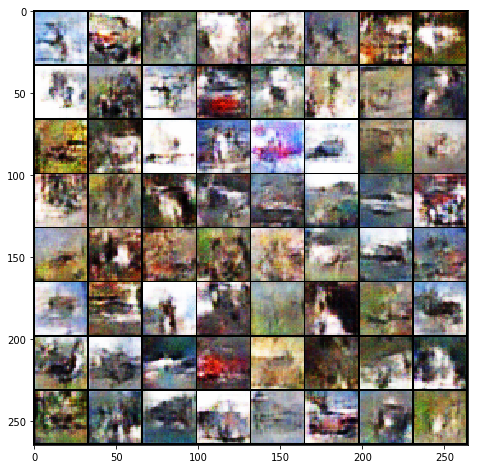

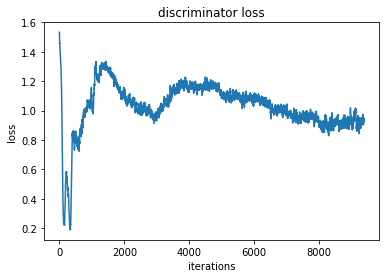

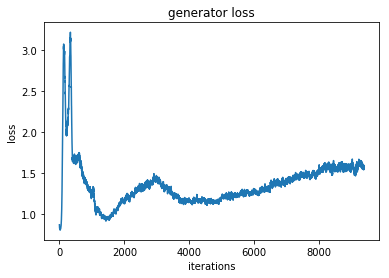

Iteration 9400/156200: dis loss = 0.8335, gen loss = 1.3610
Iteration 9450/156200: dis loss = 1.0940, gen loss = 1.9687
Iteration 9500/156200: dis loss = 1.0566, gen loss = 0.9555
Iteration 9550/156200: dis loss = 0.9002, gen loss = 0.9993
Iteration 9600/156200: dis loss = 0.7778, gen loss = 1.3979
Iteration 9650/156200: dis loss = 0.6049, gen loss = 1.6369
Iteration 9700/156200: dis loss = 0.7151, gen loss = 2.4381
Iteration 9750/156200: dis loss = 0.6868, gen loss = 2.5356
Iteration 9800/156200: dis loss = 0.9232, gen loss = 0.9267
Iteration 9850/156200: dis loss = 0.9130, gen loss = 0.8467
Iteration 9900/156200: dis loss = 0.9963, gen loss = 1.8050
Iteration 9950/156200: dis loss = 1.2483, gen loss = 2.3207
Iteration 10000/156200: dis loss = 1.3150, gen loss = 0.7419
Iteration 10050/156200: dis loss = 0.7943, gen loss = 1.0076
Iteration 10100/156200: dis loss = 0.8614, gen loss = 1.6541
Iteration 10150/156200: dis loss = 0.7921, gen loss = 1.3143
Iteration 10200/156200: dis loss = 0

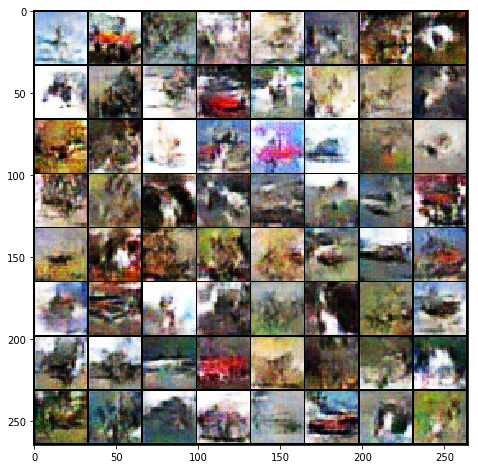

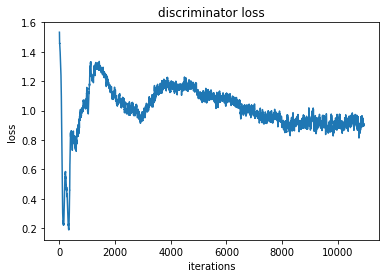

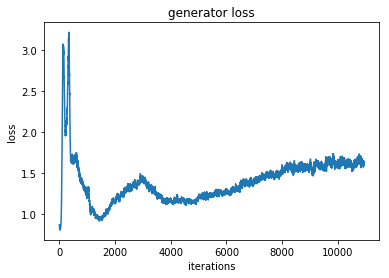

Iteration 10950/156200: dis loss = 0.7862, gen loss = 1.3521
Iteration 11000/156200: dis loss = 0.8762, gen loss = 1.7282
Iteration 11050/156200: dis loss = 1.0192, gen loss = 0.8059
Iteration 11100/156200: dis loss = 0.8712, gen loss = 2.3037
Iteration 11150/156200: dis loss = 1.2953, gen loss = 1.6704
Iteration 11200/156200: dis loss = 0.8683, gen loss = 1.2029
Iteration 11250/156200: dis loss = 0.5854, gen loss = 2.9121
Iteration 11300/156200: dis loss = 1.1508, gen loss = 1.1174
Iteration 11350/156200: dis loss = 1.0798, gen loss = 0.7246
Iteration 11400/156200: dis loss = 0.7452, gen loss = 1.3533
Iteration 11450/156200: dis loss = 1.2589, gen loss = 0.3143
Iteration 11500/156200: dis loss = 0.7887, gen loss = 1.9271
Iteration 11550/156200: dis loss = 0.6898, gen loss = 1.6430
Iteration 11600/156200: dis loss = 0.6658, gen loss = 2.3612
Iteration 11650/156200: dis loss = 0.9686, gen loss = 2.3321
Iteration 11700/156200: dis loss = 0.9142, gen loss = 0.9107
Iteration 11750/156200: 

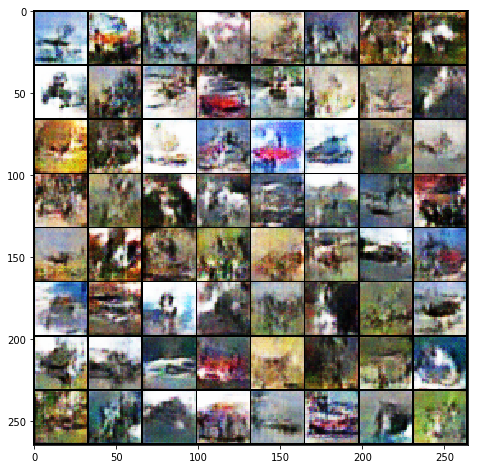

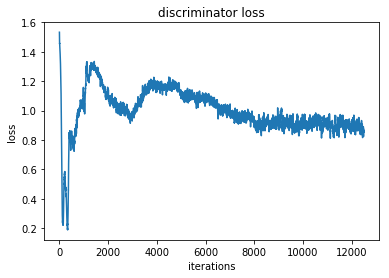

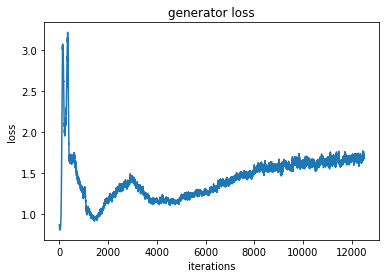

Iteration 12500/156200: dis loss = 1.1374, gen loss = 2.9155
Iteration 12550/156200: dis loss = 0.8537, gen loss = 2.1072
Iteration 12600/156200: dis loss = 0.5559, gen loss = 1.9169
Iteration 12650/156200: dis loss = 0.9247, gen loss = 2.2109
Iteration 12700/156200: dis loss = 1.1205, gen loss = 0.9525
Iteration 12750/156200: dis loss = 0.9463, gen loss = 2.7623
Iteration 12800/156200: dis loss = 0.6511, gen loss = 2.2031
Iteration 12850/156200: dis loss = 0.7874, gen loss = 1.6792
Iteration 12900/156200: dis loss = 0.8278, gen loss = 2.2196
Iteration 12950/156200: dis loss = 0.9054, gen loss = 1.2062
Iteration 13000/156200: dis loss = 0.7275, gen loss = 2.2627
Iteration 13050/156200: dis loss = 0.6335, gen loss = 1.7381
Iteration 13100/156200: dis loss = 1.0527, gen loss = 1.0308
Iteration 13150/156200: dis loss = 1.0005, gen loss = 0.8662
Iteration 13200/156200: dis loss = 0.7891, gen loss = 1.6522
Iteration 13250/156200: dis loss = 0.8048, gen loss = 1.1515
Iteration 13300/156200: 

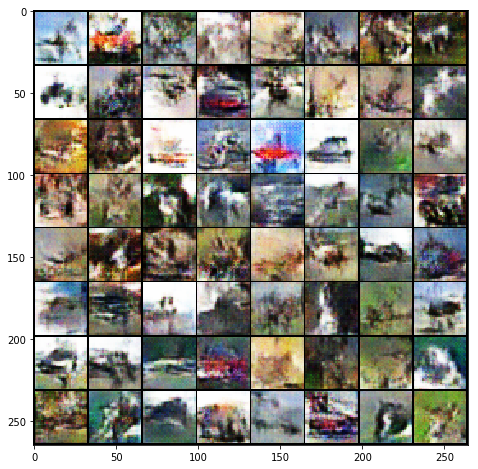

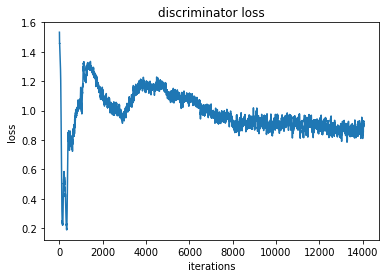

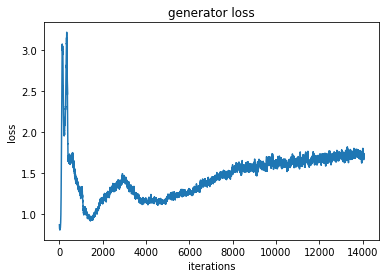

Iteration 14100/156200: dis loss = 1.3127, gen loss = 0.7075
Iteration 14150/156200: dis loss = 0.8636, gen loss = 1.8969
Iteration 14200/156200: dis loss = 1.2850, gen loss = 2.4010
Iteration 14250/156200: dis loss = 0.8796, gen loss = 3.1085
Iteration 14300/156200: dis loss = 0.7192, gen loss = 1.5381
Iteration 14350/156200: dis loss = 0.7032, gen loss = 1.7627
Iteration 14400/156200: dis loss = 0.7460, gen loss = 1.0572
Iteration 14450/156200: dis loss = 0.8409, gen loss = 2.5267
Iteration 14500/156200: dis loss = 0.6441, gen loss = 1.2424
Iteration 14550/156200: dis loss = 0.6884, gen loss = 2.0058
Iteration 14600/156200: dis loss = 0.8546, gen loss = 1.2258
Iteration 14650/156200: dis loss = 0.9985, gen loss = 0.9798
Iteration 14700/156200: dis loss = 0.9021, gen loss = 2.4251
Iteration 14750/156200: dis loss = 0.7265, gen loss = 1.8330
Iteration 14800/156200: dis loss = 0.7251, gen loss = 1.6626
Iteration 14850/156200: dis loss = 0.8413, gen loss = 2.7854
Iteration 14900/156200: 

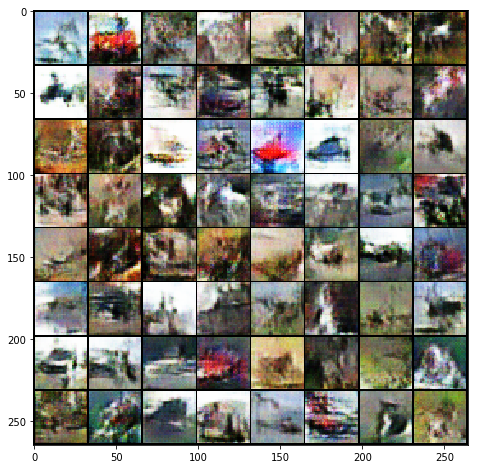

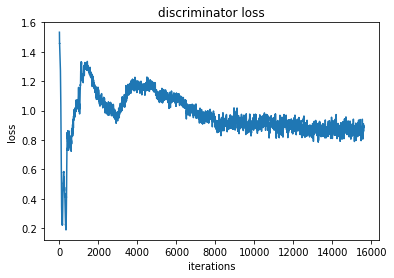

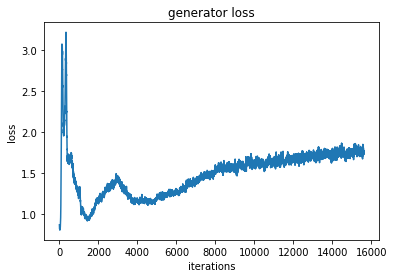

Iteration 15650/156200: dis loss = 0.7529, gen loss = 2.5572
Iteration 15700/156200: dis loss = 0.8582, gen loss = 1.6264
Iteration 15750/156200: dis loss = 0.7252, gen loss = 1.4163
Iteration 15800/156200: dis loss = 0.9148, gen loss = 1.3138
Iteration 15850/156200: dis loss = 0.7705, gen loss = 1.2585
Iteration 15900/156200: dis loss = 0.8339, gen loss = 1.4567
Iteration 15950/156200: dis loss = 0.6685, gen loss = 1.1665
Iteration 16000/156200: dis loss = 1.4884, gen loss = 2.4800
Iteration 16050/156200: dis loss = 0.8117, gen loss = 1.3732
Iteration 16100/156200: dis loss = 0.6360, gen loss = 2.4282
Iteration 16150/156200: dis loss = 0.8281, gen loss = 1.2802
Iteration 16200/156200: dis loss = 1.2716, gen loss = 0.7201
Iteration 16250/156200: dis loss = 0.5872, gen loss = 2.1535
Iteration 16300/156200: dis loss = 0.9325, gen loss = 1.0647
Iteration 16350/156200: dis loss = 0.6650, gen loss = 1.9437
Iteration 16400/156200: dis loss = 0.8284, gen loss = 2.8937
Iteration 16450/156200: 

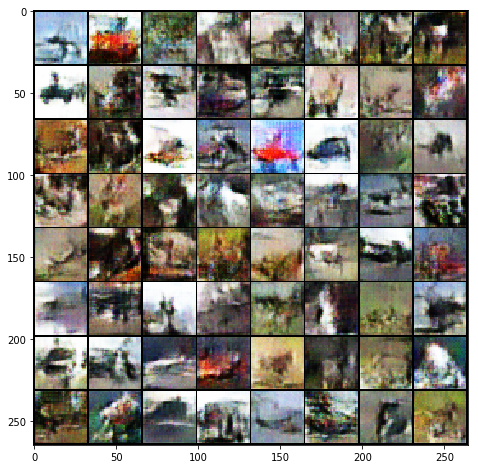

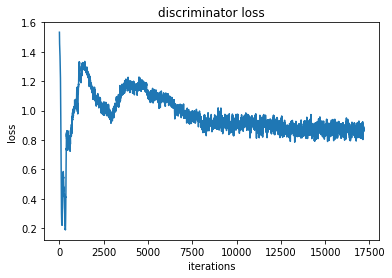

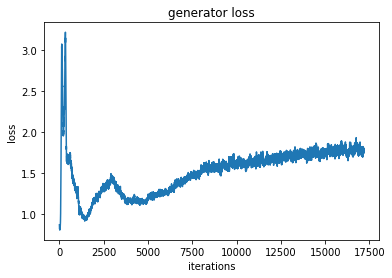

Iteration 17200/156200: dis loss = 1.0421, gen loss = 0.7687
Iteration 17250/156200: dis loss = 0.7335, gen loss = 1.5353
Iteration 17300/156200: dis loss = 0.7539, gen loss = 2.3773
Iteration 17350/156200: dis loss = 1.3236, gen loss = 0.5501
Iteration 17400/156200: dis loss = 0.4351, gen loss = 1.8642
Iteration 17450/156200: dis loss = 0.7352, gen loss = 1.4872
Iteration 17500/156200: dis loss = 0.7034, gen loss = 2.2239
Iteration 17550/156200: dis loss = 1.0031, gen loss = 1.0689
Iteration 17600/156200: dis loss = 0.8573, gen loss = 1.6734
Iteration 17650/156200: dis loss = 0.6339, gen loss = 1.8378
Iteration 17700/156200: dis loss = 0.7499, gen loss = 1.5750
Iteration 17750/156200: dis loss = 0.9368, gen loss = 1.4776
Iteration 17800/156200: dis loss = 1.1216, gen loss = 0.7648
Iteration 17850/156200: dis loss = 1.0560, gen loss = 3.1927
Iteration 17900/156200: dis loss = 0.8494, gen loss = 0.9476
Iteration 17950/156200: dis loss = 0.9505, gen loss = 0.9969
Iteration 18000/156200: 

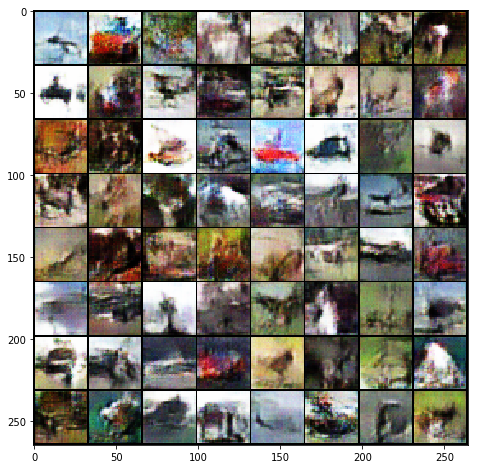

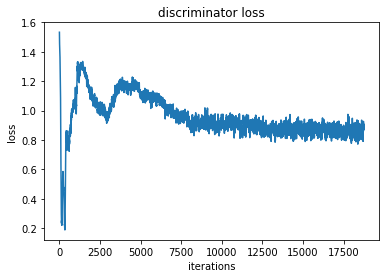

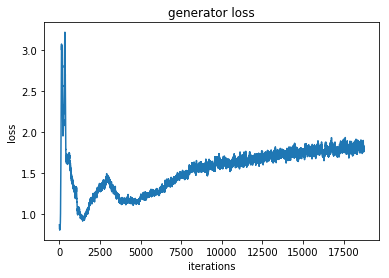

Iteration 18750/156200: dis loss = 0.7965, gen loss = 1.7740
Iteration 18800/156200: dis loss = 0.7664, gen loss = 3.2208
Iteration 18850/156200: dis loss = 0.6701, gen loss = 1.8897
Iteration 18900/156200: dis loss = 0.9797, gen loss = 1.0088
Iteration 18950/156200: dis loss = 0.8329, gen loss = 1.5869
Iteration 19000/156200: dis loss = 0.5013, gen loss = 1.7514
Iteration 19050/156200: dis loss = 0.9601, gen loss = 2.6808
Iteration 19100/156200: dis loss = 1.3044, gen loss = 2.6205
Iteration 19150/156200: dis loss = 0.7592, gen loss = 1.3661
Iteration 19200/156200: dis loss = 1.0803, gen loss = 0.7069
Iteration 19250/156200: dis loss = 0.9653, gen loss = 2.2919
Iteration 19300/156200: dis loss = 0.6836, gen loss = 1.5977
Iteration 19350/156200: dis loss = 1.0718, gen loss = 2.2991
Iteration 19400/156200: dis loss = 0.9788, gen loss = 1.3129
Iteration 19450/156200: dis loss = 1.0293, gen loss = 0.7968
Iteration 19500/156200: dis loss = 0.9364, gen loss = 1.2929
Iteration 19550/156200: 

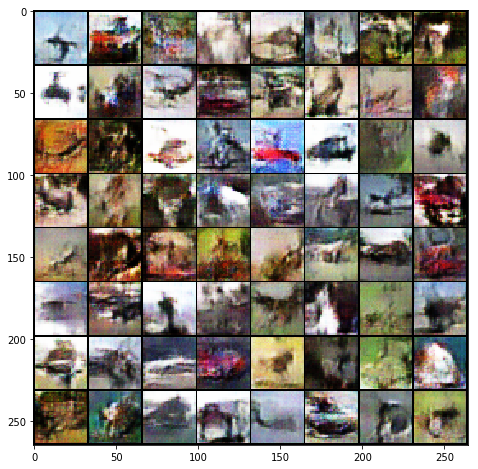

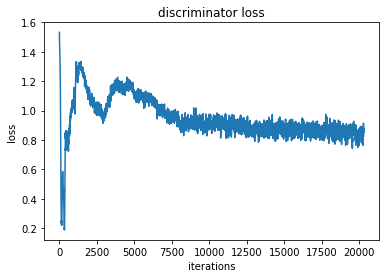

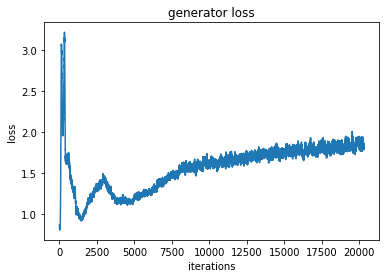

Iteration 20350/156200: dis loss = 0.6354, gen loss = 2.2416
Iteration 20400/156200: dis loss = 0.5663, gen loss = 1.9968
Iteration 20450/156200: dis loss = 0.8789, gen loss = 1.3087
Iteration 20500/156200: dis loss = 0.5355, gen loss = 1.6405
Iteration 20550/156200: dis loss = 0.5938, gen loss = 2.4672
Iteration 20600/156200: dis loss = 0.8971, gen loss = 1.4940
Iteration 20650/156200: dis loss = 0.7051, gen loss = 1.2260
Iteration 20700/156200: dis loss = 0.8705, gen loss = 2.0993
Iteration 20750/156200: dis loss = 0.6529, gen loss = 2.0092
Iteration 20800/156200: dis loss = 1.3918, gen loss = 2.1006
Iteration 20850/156200: dis loss = 0.9480, gen loss = 0.9967
Iteration 20900/156200: dis loss = 0.7690, gen loss = 2.2206
Iteration 20950/156200: dis loss = 0.9933, gen loss = 2.3244
Iteration 21000/156200: dis loss = 0.6629, gen loss = 1.6262
Iteration 21050/156200: dis loss = 0.9613, gen loss = 0.8834
Iteration 21100/156200: dis loss = 0.7109, gen loss = 1.3416
Iteration 21150/156200: 

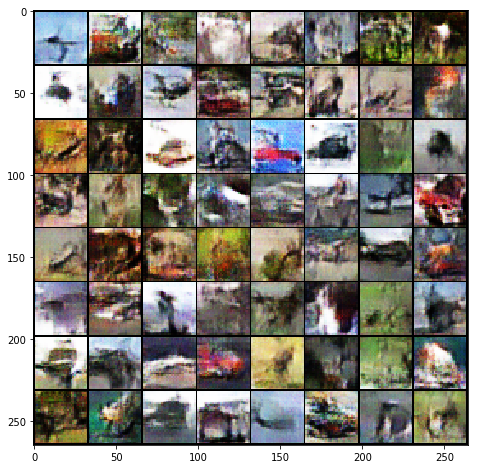

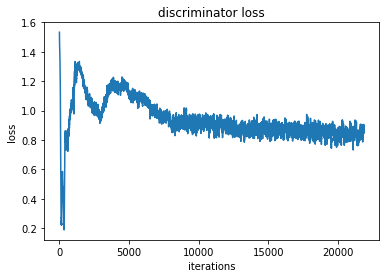

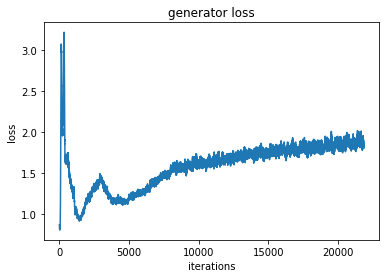

Iteration 21900/156200: dis loss = 0.8829, gen loss = 2.6166
Iteration 21950/156200: dis loss = 1.2286, gen loss = 1.9631
Iteration 22000/156200: dis loss = 0.9713, gen loss = 1.4934
Iteration 22050/156200: dis loss = 0.9060, gen loss = 1.5485
Iteration 22100/156200: dis loss = 1.1852, gen loss = 1.3549
Iteration 22150/156200: dis loss = 0.5925, gen loss = 1.9789
Iteration 22200/156200: dis loss = 0.8818, gen loss = 2.2582
Iteration 22250/156200: dis loss = 0.7564, gen loss = 1.6658
Iteration 22300/156200: dis loss = 1.1038, gen loss = 1.3565
Iteration 22350/156200: dis loss = 1.0191, gen loss = 1.5259
Iteration 22400/156200: dis loss = 1.0422, gen loss = 2.2053
Iteration 22450/156200: dis loss = 0.9248, gen loss = 0.8246
Iteration 22500/156200: dis loss = 0.8307, gen loss = 2.0439
Iteration 22550/156200: dis loss = 1.0540, gen loss = 0.8945
Iteration 22600/156200: dis loss = 1.1339, gen loss = 2.1184
Iteration 22650/156200: dis loss = 0.8803, gen loss = 2.4647
Iteration 22700/156200: 

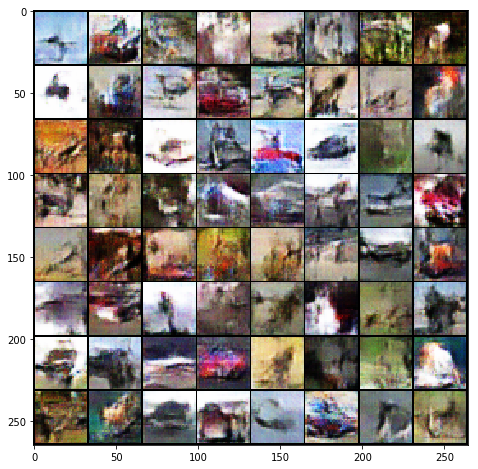

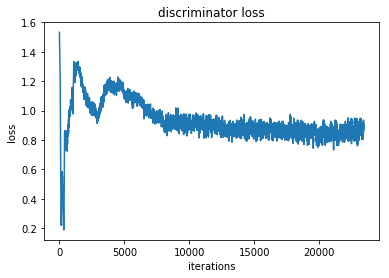

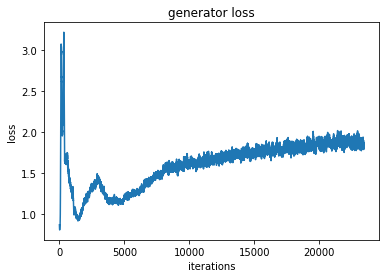

Iteration 23450/156200: dis loss = 1.0133, gen loss = 1.1282
Iteration 23500/156200: dis loss = 0.7523, gen loss = 1.6549
Iteration 23550/156200: dis loss = 0.6928, gen loss = 2.1621
Iteration 23600/156200: dis loss = 0.7627, gen loss = 1.3755
Iteration 23650/156200: dis loss = 0.7991, gen loss = 2.7860
Iteration 23700/156200: dis loss = 1.2071, gen loss = 2.6163
Iteration 23750/156200: dis loss = 0.8215, gen loss = 1.4565
Iteration 23800/156200: dis loss = 1.4930, gen loss = 0.6944
Iteration 23850/156200: dis loss = 0.5356, gen loss = 2.3924
Iteration 23900/156200: dis loss = 0.6115, gen loss = 1.6262
Iteration 23950/156200: dis loss = 0.8552, gen loss = 2.0786
Iteration 24000/156200: dis loss = 0.6221, gen loss = 1.5916
Iteration 24050/156200: dis loss = 0.7998, gen loss = 1.4872
Iteration 24100/156200: dis loss = 0.7740, gen loss = 1.7673
Iteration 24150/156200: dis loss = 0.7465, gen loss = 2.4285
Iteration 24200/156200: dis loss = 0.8747, gen loss = 1.1052
Iteration 24250/156200: 

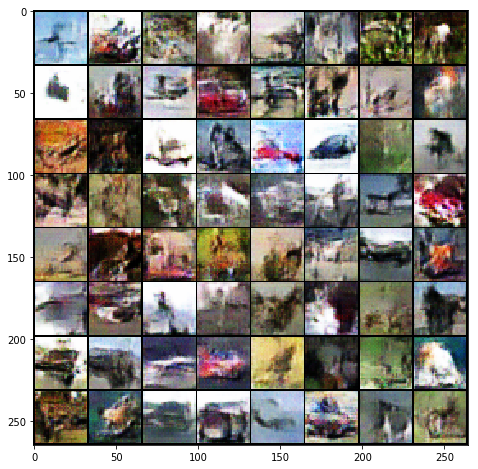

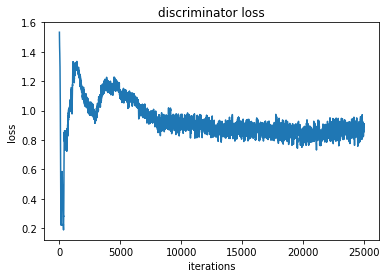

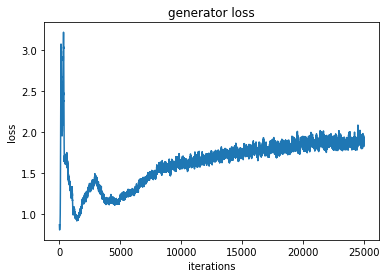

Iteration 25000/156200: dis loss = 1.4081, gen loss = 2.8641
Iteration 25050/156200: dis loss = 0.7252, gen loss = 2.6666
Iteration 25100/156200: dis loss = 1.7768, gen loss = 0.9936
Iteration 25150/156200: dis loss = 1.1572, gen loss = 0.9237
Iteration 25200/156200: dis loss = 0.9169, gen loss = 1.9263
Iteration 25250/156200: dis loss = 1.1249, gen loss = 2.5175
Iteration 25300/156200: dis loss = 1.3424, gen loss = 2.9839
Iteration 25350/156200: dis loss = 0.5495, gen loss = 2.0674
Iteration 25400/156200: dis loss = 0.6131, gen loss = 2.0530
Iteration 25450/156200: dis loss = 1.0353, gen loss = 3.0451
Iteration 25500/156200: dis loss = 0.6715, gen loss = 1.5567
Iteration 25550/156200: dis loss = 0.5492, gen loss = 2.0939
Iteration 25600/156200: dis loss = 0.7919, gen loss = 2.3025
Iteration 25650/156200: dis loss = 0.9803, gen loss = 1.0011
Iteration 25700/156200: dis loss = 0.7098, gen loss = 2.0088
Iteration 25750/156200: dis loss = 0.6085, gen loss = 2.1769
Iteration 25800/156200: 

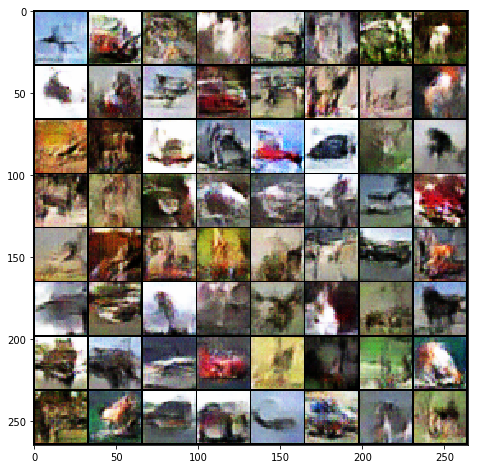

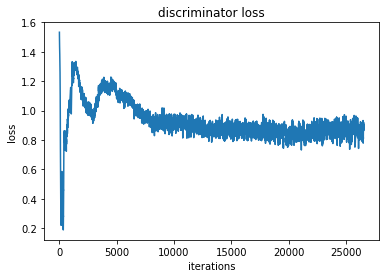

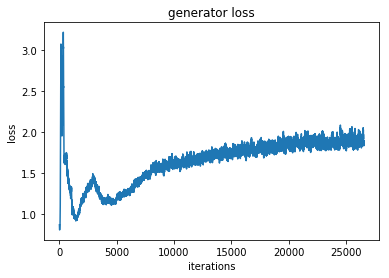

Iteration 26600/156200: dis loss = 0.7060, gen loss = 1.5598
Iteration 26650/156200: dis loss = 1.0990, gen loss = 1.8047
Iteration 26700/156200: dis loss = 0.5680, gen loss = 2.2840
Iteration 26750/156200: dis loss = 0.8552, gen loss = 3.4990
Iteration 26800/156200: dis loss = 0.6156, gen loss = 1.6556
Iteration 26850/156200: dis loss = 0.8747, gen loss = 1.7863
Iteration 26900/156200: dis loss = 0.5264, gen loss = 2.6116
Iteration 26950/156200: dis loss = 0.7124, gen loss = 3.0199
Iteration 27000/156200: dis loss = 0.6633, gen loss = 2.4681
Iteration 27050/156200: dis loss = 1.1653, gen loss = 0.9812
Iteration 27100/156200: dis loss = 0.8757, gen loss = 1.6179
Iteration 27150/156200: dis loss = 0.7561, gen loss = 2.4544
Iteration 27200/156200: dis loss = 1.0504, gen loss = 0.9525
Iteration 27250/156200: dis loss = 0.8889, gen loss = 1.7390
Iteration 27300/156200: dis loss = 0.7969, gen loss = 1.7190
Iteration 27350/156200: dis loss = 1.0062, gen loss = 1.2579
Iteration 27400/156200: 

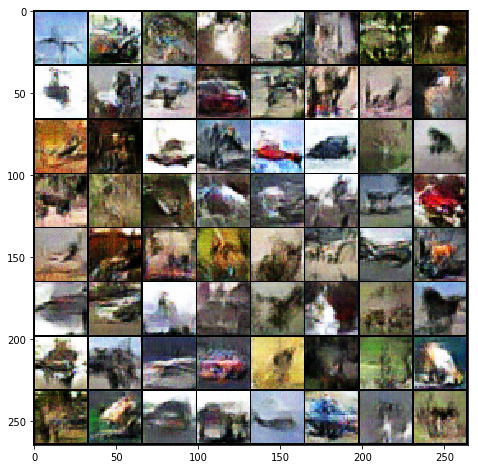

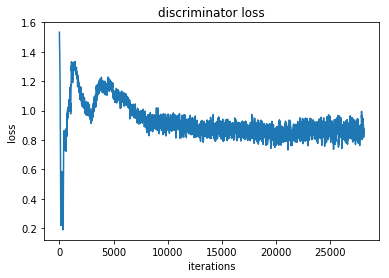

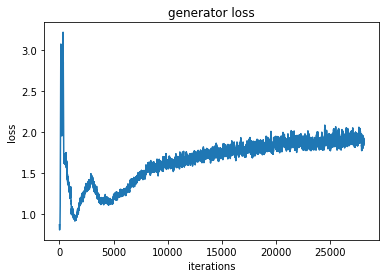

Iteration 28150/156200: dis loss = 0.7602, gen loss = 2.5048
Iteration 28200/156200: dis loss = 0.6395, gen loss = 1.9845
Iteration 28250/156200: dis loss = 0.8513, gen loss = 1.3852
Iteration 28300/156200: dis loss = 0.3968, gen loss = 2.5729
Iteration 28350/156200: dis loss = 0.6907, gen loss = 2.6057
Iteration 28400/156200: dis loss = 0.7338, gen loss = 2.3176
Iteration 28450/156200: dis loss = 0.8897, gen loss = 2.9188
Iteration 28500/156200: dis loss = 0.6389, gen loss = 2.5401
Iteration 28550/156200: dis loss = 0.7949, gen loss = 0.8311
Iteration 28600/156200: dis loss = 0.9433, gen loss = 1.0027
Iteration 28650/156200: dis loss = 0.6911, gen loss = 1.3808
Iteration 28700/156200: dis loss = 1.0176, gen loss = 1.4542
Iteration 28750/156200: dis loss = 0.8790, gen loss = 2.3665
Iteration 28800/156200: dis loss = 0.8182, gen loss = 2.9407
Iteration 28850/156200: dis loss = 0.7684, gen loss = 1.6618
Iteration 28900/156200: dis loss = 0.6151, gen loss = 1.8942
Iteration 28950/156200: 

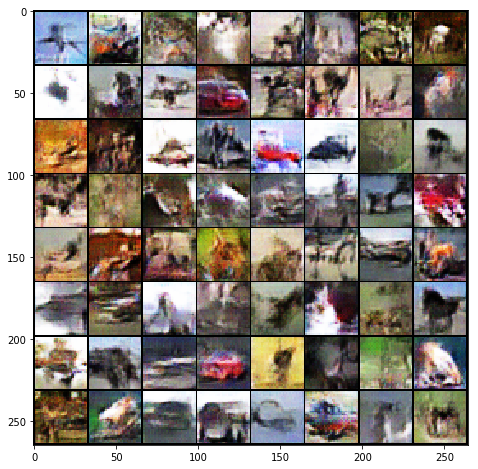

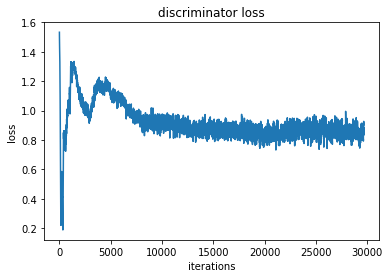

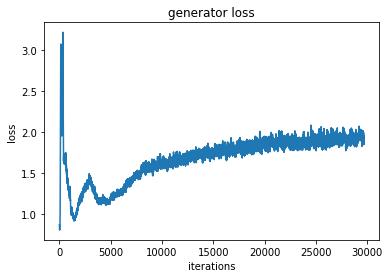

Iteration 29700/156200: dis loss = 0.7201, gen loss = 2.3198
Iteration 29750/156200: dis loss = 0.6113, gen loss = 2.4182
Iteration 29800/156200: dis loss = 1.0687, gen loss = 0.6986
Iteration 29850/156200: dis loss = 1.0930, gen loss = 0.8319
Iteration 29900/156200: dis loss = 0.8912, gen loss = 0.9555
Iteration 29950/156200: dis loss = 0.5399, gen loss = 1.8061
Iteration 30000/156200: dis loss = 0.7819, gen loss = 1.2801
Iteration 30050/156200: dis loss = 0.6564, gen loss = 2.5934
Iteration 30100/156200: dis loss = 0.5962, gen loss = 2.8826
Iteration 30150/156200: dis loss = 0.6158, gen loss = 2.4484
Iteration 30200/156200: dis loss = 0.3503, gen loss = 2.8571
Iteration 30250/156200: dis loss = 0.6174, gen loss = 1.5124
Iteration 30300/156200: dis loss = 0.9035, gen loss = 1.9745
Iteration 30350/156200: dis loss = 0.6314, gen loss = 2.0608
Iteration 30400/156200: dis loss = 0.8689, gen loss = 1.0262
Iteration 30450/156200: dis loss = 0.9317, gen loss = 1.0785
Iteration 30500/156200: 

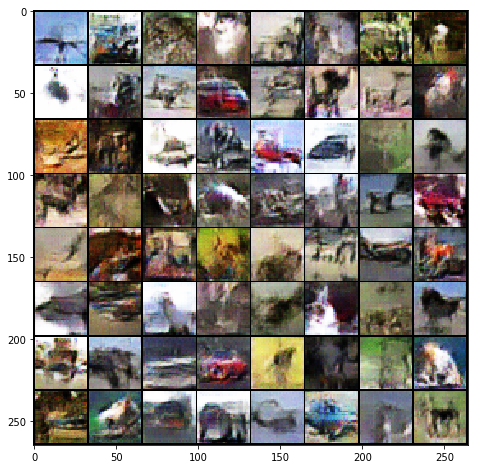

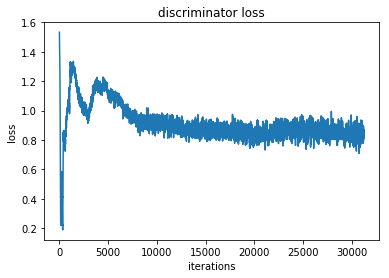

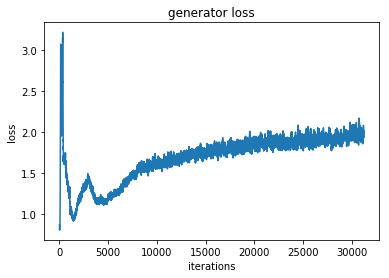

Iteration 31250/156200: dis loss = 0.8748, gen loss = 1.0294
Iteration 31300/156200: dis loss = 0.6145, gen loss = 2.2499
Iteration 31350/156200: dis loss = 0.8068, gen loss = 1.6235
Iteration 31400/156200: dis loss = 0.4734, gen loss = 1.9628
Iteration 31450/156200: dis loss = 0.9108, gen loss = 0.9409
Iteration 31500/156200: dis loss = 0.7892, gen loss = 1.3193
Iteration 31550/156200: dis loss = 0.6295, gen loss = 2.2341
Iteration 31600/156200: dis loss = 0.6682, gen loss = 1.8515
Iteration 31650/156200: dis loss = 1.0192, gen loss = 2.8842
Iteration 31700/156200: dis loss = 0.9688, gen loss = 1.4687
Iteration 31750/156200: dis loss = 1.1934, gen loss = 3.1473
Iteration 31800/156200: dis loss = 1.1742, gen loss = 0.7216
Iteration 31850/156200: dis loss = 0.6045, gen loss = 2.9601
Iteration 31900/156200: dis loss = 0.7836, gen loss = 1.4530
Iteration 31950/156200: dis loss = 0.8107, gen loss = 1.1833
Iteration 32000/156200: dis loss = 1.1349, gen loss = 0.9657
Iteration 32050/156200: 

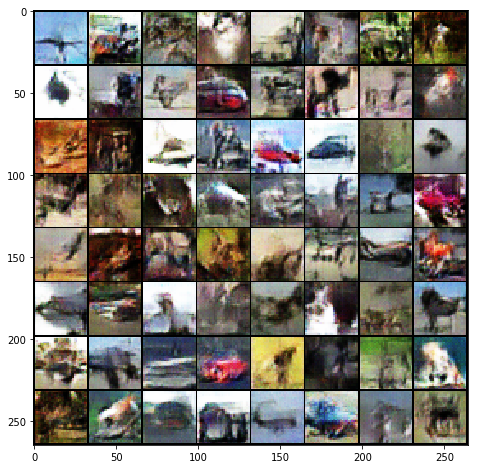

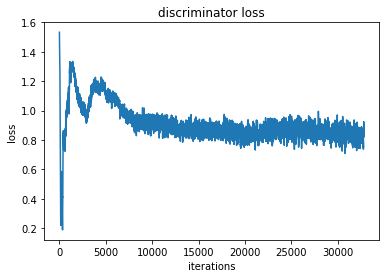

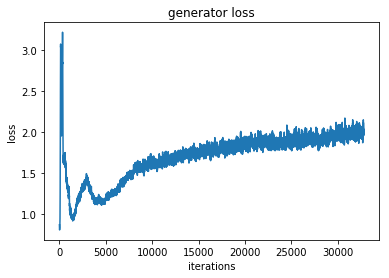

Iteration 32850/156200: dis loss = 0.6680, gen loss = 1.6760
Iteration 32900/156200: dis loss = 0.6674, gen loss = 1.5948
Iteration 32950/156200: dis loss = 0.8643, gen loss = 3.0246
Iteration 33000/156200: dis loss = 0.7373, gen loss = 2.4602
Iteration 33050/156200: dis loss = 0.7539, gen loss = 1.6901
Iteration 33100/156200: dis loss = 0.5407, gen loss = 1.8525
Iteration 33150/156200: dis loss = 0.6185, gen loss = 2.8275
Iteration 33200/156200: dis loss = 0.6747, gen loss = 2.8673
Iteration 33250/156200: dis loss = 0.7599, gen loss = 2.3288
Iteration 33300/156200: dis loss = 0.6463, gen loss = 1.9235
Iteration 33350/156200: dis loss = 0.6731, gen loss = 2.7186
Iteration 33400/156200: dis loss = 0.7129, gen loss = 1.9544
Iteration 33450/156200: dis loss = 0.5154, gen loss = 1.9079
Iteration 33500/156200: dis loss = 0.8331, gen loss = 1.1585
Iteration 33550/156200: dis loss = 0.8793, gen loss = 1.3438
Iteration 33600/156200: dis loss = 0.5745, gen loss = 1.7004
Iteration 33650/156200: 

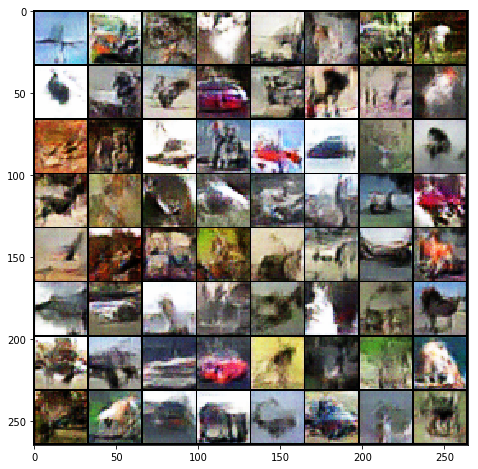

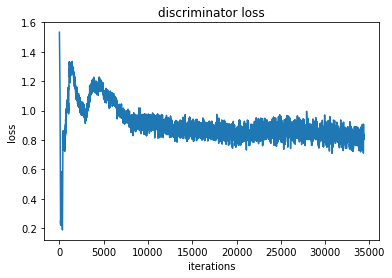

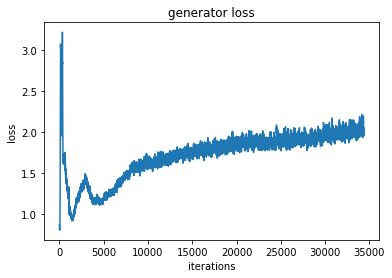

Iteration 34400/156200: dis loss = 0.7939, gen loss = 2.2151
Iteration 34450/156200: dis loss = 0.5953, gen loss = 1.5599
Iteration 34500/156200: dis loss = 1.1008, gen loss = 1.8520
Iteration 34550/156200: dis loss = 1.5048, gen loss = 2.7653
Iteration 34600/156200: dis loss = 0.6638, gen loss = 2.6688
Iteration 34650/156200: dis loss = 0.6334, gen loss = 2.3294
Iteration 34700/156200: dis loss = 0.8668, gen loss = 3.6985
Iteration 34750/156200: dis loss = 0.6394, gen loss = 2.1465
Iteration 34800/156200: dis loss = 0.6212, gen loss = 1.7233
Iteration 34850/156200: dis loss = 0.6062, gen loss = 1.7102
Iteration 34900/156200: dis loss = 0.5126, gen loss = 1.8787
Iteration 34950/156200: dis loss = 0.7452, gen loss = 1.9791
Iteration 35000/156200: dis loss = 1.0042, gen loss = 1.0006
Iteration 35050/156200: dis loss = 0.6824, gen loss = 2.5164
Iteration 35100/156200: dis loss = 0.5875, gen loss = 2.3041
Iteration 35150/156200: dis loss = 1.0826, gen loss = 1.1063
Iteration 35200/156200: 

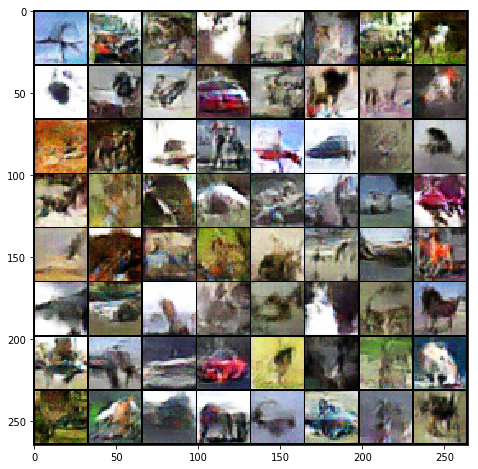

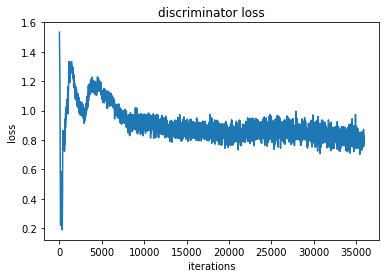

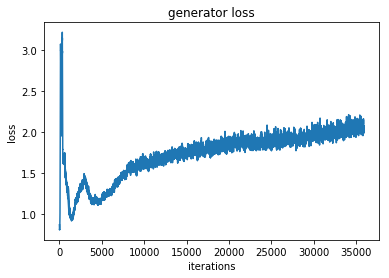

Iteration 35950/156200: dis loss = 0.5051, gen loss = 2.0832
Iteration 36000/156200: dis loss = 0.4716, gen loss = 2.4730
Iteration 36050/156200: dis loss = 1.1371, gen loss = 1.4221
Iteration 36100/156200: dis loss = 0.4433, gen loss = 2.0211
Iteration 36150/156200: dis loss = 0.6794, gen loss = 1.7979
Iteration 36200/156200: dis loss = 0.6697, gen loss = 2.0513
Iteration 36250/156200: dis loss = 0.8339, gen loss = 2.2909
Iteration 36300/156200: dis loss = 0.6113, gen loss = 2.2857
Iteration 36350/156200: dis loss = 0.5386, gen loss = 2.3461
Iteration 36400/156200: dis loss = 0.9250, gen loss = 1.3045


In [ ]:
tf.reset_default_graph()
set_seed(21)

mdel_path = 'model/dcgan_gpu.ckpt'

with tf.Session() as sess:
    #with tf.device('/cpu:0'):
    with tf.device('/gpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        
        # restore
        isrestore = False
        if os.path.isfile(mdel_path):
            dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
            gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
            saver = tf.train.Saver(dis_var_list + gen_var_list)
            saver.restore(sess, mdel_path)
            isrestore = True
        
        # train
        dcgan.train(sess, train_samples, train_labels)
        
        #save
        if not isrestore:
            dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
            gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
            saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, mdel_path)